# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.338049,False,-4.233312
1,-1.580636,False,-3.797205
2,-1.875103,False,-4.676381
3,-0.455144,False,-0.943806
4,0.281895,False,0.341403
...,...,...,...
995,0.557417,True,8.441512
996,1.168337,True,7.231467
997,0.156181,False,-1.662032
998,-0.757368,False,-1.928380


<AxesSubplot: xlabel='v0'>

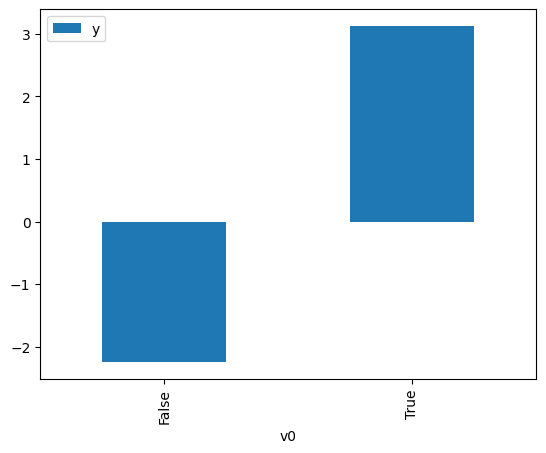

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

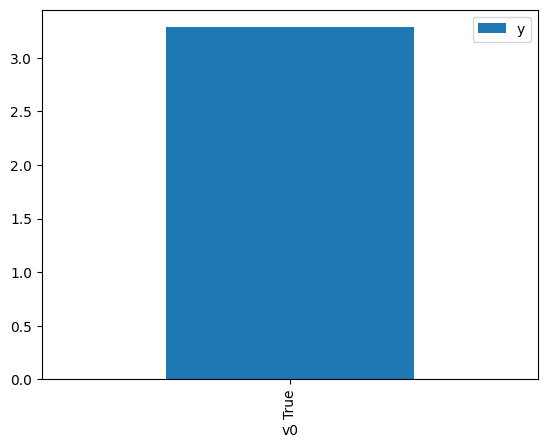

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.648627,False,-3.658266,0.786290,1.271796
1,-0.265916,False,-0.555883,0.619202,1.614982
2,0.295765,False,1.920820,0.329107,3.038524
3,0.281895,False,0.341403,0.335674,2.979082
4,-1.829257,False,-6.663657,0.978578,1.021891
...,...,...,...,...,...
995,-0.791864,False,-2.826509,0.833177,1.200225
996,-0.897267,False,-3.021374,0.862142,1.159901
997,-0.411101,False,-2.201869,0.689102,1.451163
998,0.460297,False,1.290784,0.256685,3.895819


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.222866,True,1.709530,0.073926,13.527050
1,0.123372,True,5.938119,0.585262,1.708636
2,-0.633061,True,3.701341,0.219344,4.559052
3,-0.051358,True,3.339940,0.492904,2.028794
4,-2.009020,True,0.066087,0.014698,68.034676
...,...,...,...,...,...
995,-1.855563,True,0.550196,0.020277,49.317670
996,-2.009020,True,0.066087,0.014698,68.034676
997,0.124480,True,3.993371,0.585836,1.706962
998,-0.323994,True,4.970284,0.352042,2.840572


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              9430.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:20:53   Log-Likelihood:                         -1440.3
No. Observations:                1000   AIC:                                      2885.
Df Residuals:                     998   BIC:                                      2895.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6862      0.025    106.808      0.000       2.637       2.736
x2             4.9605      0.061     80.770      0.000       4.840       5.081
==============================================================================
Omnibus:                        0.428   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.807   Jarque-Bera (JB):                0.312
Skew:                           0.010   Prob(JB):                        0.856
Kurtosis:                       3.084   Cond. No.                         2.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""